In [103]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import RidgeCV
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import pandas as pd
sys.path.append("..")

In [40]:
class config:
    USE_CACHE = True
    CACHE_DIR = "/Users/caseydurfee/msds/data_mining_final_project/cache"

from COVID_data import all_data
data = all_data.get_all_data(config)

## COVID isn't fair
COVID has affected people in different parts of the country very differently.

For example, since the start of COVID, The Bronx has a COVID fatality rate of .005431.  Milwaukee has a rate of .002284.  If all of America had the same rate as the Bronx, the country would have had 1.8 Million deaths from COVID so far. If all of America had the same rate as Milwaukee, we would be at 750,000 deaths. That's a difference of over a million lives.

In [14]:
US_POPULATION = 330000000
bronx_deaths = data.DEATH_RATE[data.County == 'Bronx'].iat[0] * US_POPULATION

milwaukee_deaths = data.DEATH_RATE[data.County == 'Milwaukee'].iat[0] * US_POPULATION
print("Bronx County: {:,}".format(round(bronx_deaths, 0)))
print("Milwaukee County: {:,}".format(round(milwaukee_deaths, 0)))

Bronx: 1,792,164.0
Milwaukee: 753,707.0


Vaccines made things even crazier. For example, in the second year of COVID, The Bronx has had a death rate lower than the national average. If all of America were like the Bronx in year 2 of the pandemic, we'd have 200,000 fewer deaths. The death rate was 3.5x higher in the first year of the pandemic than the second. 

In [22]:
## NOTE: multiply by 2 to get the death rate for both years of the pandemic
y2_bronx_rate_deaths = 2 * data.DEATH_RATE_SECOND_YEAR[data.County == 'Bronx'].iat[0] * US_POPULATION


print("Bronx County (year 2 rate): {:,}".format(round(y2_bronx_rate_deaths, 0)))


print(data.DEATH_RATE_FIRST_YEAR[data.County == 'Bronx'].iat[0] / 
        data.DEATH_RATE_SECOND_YEAR[data.County == 'Bronx'].iat[0])

Bronx County (year 2 rate): 790,209.0
3.5359246171967014


In [36]:
complete_big_county_data = data[(data.DEATHS_SECOND_YEAR > 0) & (data.DEATHS_FIRST_YEAR > 0) & (data.POPN > 50000)]

death_ratio = (complete_big_county_data.DEATHS_SECOND_YEAR / complete_big_county_data.DEATHS_FIRST_YEAR)

In [39]:
death_ratio.median()

0.9816742208046556

## Can we understand these discrepancies?

So, there's huge variance here, but perhaps it's natural variance. Let's look at the distribution of fatality rates.

<AxesSubplot:>

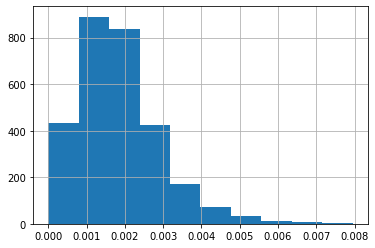

In [42]:
%matplotlib inline
data.DEATH_RATE_FIRST_YEAR.hist()

<AxesSubplot:>

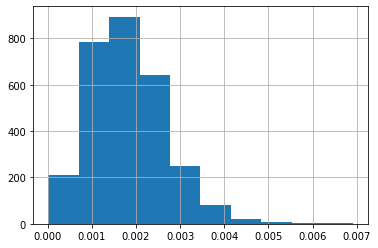

In [41]:
data.DEATH_RATE_SECOND_YEAR.hist()

Well, that's not very symmetrical. There appears to be a pretty long tail of counties with higher than average death rates.

Because death rates varied so widely in year one versus year two, I am going to try to fit one model per year. The goal will be to predict whether a county will have a high COVID fatality rate based on the demographic data.

In [83]:
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

### drop all columns with deaths information in them; the rest should be safe
death_cols = [x for x in data.columns if x.find("DEATH") > -1]

### drop all columns that are 'object' types.

obj_cols = list(data.dtypes[data.dtypes == "object"].index)


X = data.dropna()

y1_quantiles = pd.qcut(X.DEATH_RATE_FIRST_YEAR, 4, labels=False)

X = X.drop(obj_cols, axis=1).drop(death_cols, axis=1)

y = (y1_quantiles == 3)


## NEXT STEPS
## 1. get rid of columns that have high numbers of na's, impute ones that have lower numbers.
## 2. need to get rid of vax coverage as a prediction factor for year 2

data.info()

Because there are so many columns (over 100), I want to try PCA to see what the highest variance columns are.

In [ ]:
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import f_classif

# fs = SelectKBest(score_func=f_classif, k=10)
# X_selected = fs.fit_transform(X, y)

# X_selected

In [111]:
feature_names = np.array(X.columns)
# plt.bar(height=importance, x=feature_names)
# plt.title("Feature importances via coefficients")
# plt.show()


scaler = StandardScaler().fit(X)

_svc = SVC().fit(scaler.transform(X), y)

sfm = SelectFromModel(_svc, threshold=-np.inf, max_features=20).fit(scaler.transform(X), y)
#.fit(scaler.transform(X), y)


#print(f"Features selected by SelectFromModel: {feature_names[sfm.get_support()]}")

print(f" selected: {feature_names[sfm.get_support()]}")
print(f" out of {feature_names}")

ValueError: when `importance_getter=='auto'`, the underlying estimator SVC should have `coef_` or `feature_importances_` attribute. Either pass a fitted estimator to feature selector or call fit before calling transform.

In [102]:



sfm = SelectFromModel(RandomForestClassifier(), threshold=-np.inf, max_features=20).fit(scaler.transform(X), y)

print(f" selected: {feature_names[sfm.get_support()]}")


 selected: ['Partial Coverage' 'Quality_of_Life_Percentile'
 'Physical_Environment_Percentile' 'ALAND_SQMI' 'REPUB_PARTISAN'
 '% Insufficient Sleep' 'Firearm Fatalities Rate' '% Hispanic'
 '% Diabetic' 'EP_NOHSDP' 'EP_AGE65' 'EP_DISABL' 'EP_MOBILE' 'EP_NOVEH'
 '% Physically Inactive' '% Alcohol-Impaired' 'MHP Rate' '% Some College'
 '% Children in Poverty' 'Income Ratio']
